In [171]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import functools as ft
import progressbar

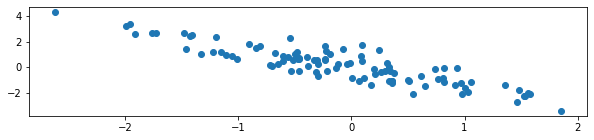

In [140]:
np.random.seed(42)

ndims = 1
ndata = 100
scale = 0.7
X = np.random.randn(ndata, ndims)
w_ = np.random.randn(ndims)  # hidden
noise_ = scale * np.random.randn(ndata)  # hidden

y_obs = X.dot(w_) + noise_

plt.figure(figsize=(10, 2))
plt.scatter(X[:, 0], y_obs)
plt.show()

In [141]:
X_tensor = tf.convert_to_tensor(X, dtype='float32')

@tf.function
def target_log_prob_fn(w):
    w_dist = tfd.Normal(loc=tf.zeros((ndims, 1)), scale=10.0, name="w")
    w_prob = tf.reduce_sum(w_dist.log_prob(w))
    
    y_dist = tfd.Normal(loc=tf.matmul(X_tensor, w), scale=scale, name="y")
    y_prob = tf.reduce_sum(y_dist.log_prob(y_obs.reshape(-1, 1)))
    return w_prob + y_prob


# Initialize the HMC transition kernel.
num_results = 1000
num_burnin_steps = 500
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        num_leapfrog_steps=4,
        step_size=0.01),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

samples, is_accepted = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=tf.zeros((ndims, 1)),
    kernel=adaptive_hmc,
    trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

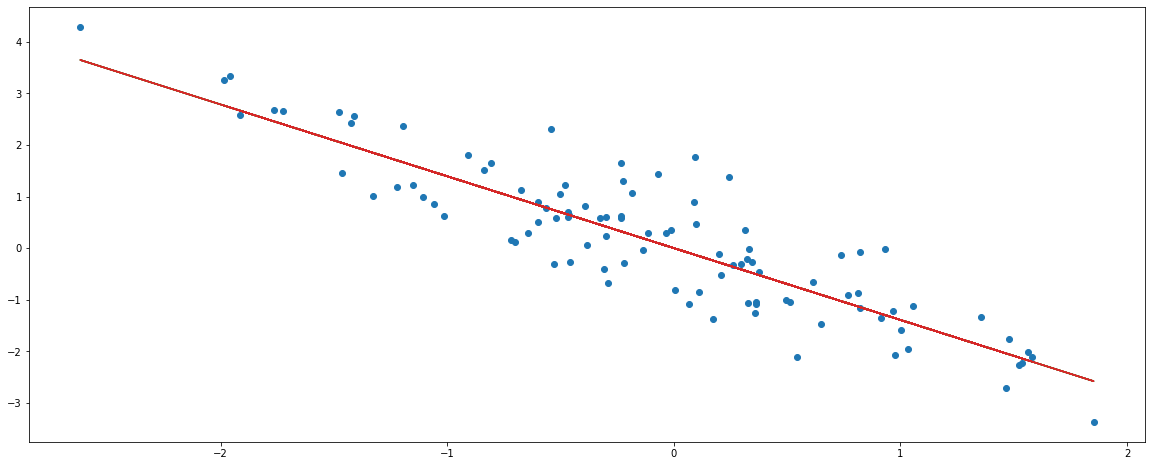

In [142]:
plt.figure(figsize=(20, 8))
plt.scatter(X[:, 0], y_obs)

for i in [0, 100, 500, 700]:
    i = 0
    y_pred = tf.matmul(X_tensor, samples[i, :, :]).numpy()
    plt.plot(X[:, 0], y_pred)
    
plt.show()

In [180]:
def define_model(input_dim=1, output_dim=1, hidden_layers=[]):
    layers = []
    layers.append(input_dim)
    for units in hidden_layers:
        layers.append(units)
    layers.append(output_dim)
    return layers
  
def get_random_initial_state(weight_prior, bias_prior, layers, overdisp=1.0):
    """Generate random initial configuration for weights and biases of a fully-connected NN
    sampled according to the specified prior distributions. This configuration can serve
    as a starting point for instance to generate a Markov chain of network configurations
    via Hamiltonian Monte Carlo which are distributed according to the posterior after having
    observed some data.
    """
    init_state = []
    for idx in range(len(layers) - 1):
        weights_shape = (layers[idx], layers[idx + 1])
        biases_shape = layers[idx + 1]
        # use overdispersion > 1 for better R-hat statistics
        weights = weight_prior.sample(tf.squeeze(weights_shape)) * overdisp
        biases = bias_prior.sample(tf.squeeze(biases_shape)) * overdisp
        init_state.extend((weights, biases))
    return init_state
           
def dense(inputs, weights, biases, activation):
    return activation(tf.matmul(inputs, weights) + biases)

def build_network(weights_list, biases_list, activation=tf.nn.relu):
    
    def model(samples, training=True):
        
        net = samples
        
        for (weights, biases) in zip(weights_list[:-1], biases_list[:-1]):
            net = dense(net, weights, biases, activation)
            
        # final linear layer
        output = tf.matmul(net, weights_list[-1]) + biases_list[-1]
        
        return tfd.Normal(loc=output, scale=1.0)

    return model

In [184]:
# define layers
layers = define_model(1, 1, [])

# define priors
weight_prior = tfp.distributions.Normal(0.0, 1.0)
bias_prior = tfp.distributions.Normal(0.0, 1.0)
    
# initialize parameters
parameters = get_random_initial_state(weight_prior, bias_prior, layers)     
weights_list, biases_list = parameters[::2], parameters[1::2]

# build model with parameters
model = build_network(weights_list, biases_list)

# test model
X_tensor = tf.convert_to_tensor(X, dtype='float32')
pred = model(X_tensor).mean().numpy()
pred[:5]

array([[-1.1572655],
       [-1.1146486],
       [-1.1673983],
       [-1.2261474],
       [-1.108213 ]], dtype=float32)

In [185]:
# log_prior
def prior_log_prob_fn(weight_prior, bias_prior, weights, biases):
    log_prob = sum([tf.reduce_sum(weight_prior.log_prob(w)) for w in weights])
    log_prob += sum([tf.reduce_sum(bias_prior.log_prob(b)) for b in biases])
    return log_prob

# log_likelihood
def bnn_log_prob_fn(x, y, weights, biases):
    network = build_network(weights, biases)
    output = network(x)
    return tf.reduce_sum(output.log_prob(y))

# log_likelihood + log_prior
def target_log_prob_fn_factory(weight_prior, bias_prior, x_train, y_train):
    
    def target_log_prob_fn(parameters, *args, **kwargs):
        weights, biases = parameters[::2], parameters[1::2]
        log_prob = bnn_log_prob_fn(x_train, y_train, weights, biases)
        log_prob += prior_log_prob_fn(weight_prior, bias_prior, weights, biases)
        return log_prob

    return target_log_prob_fn
    
target_log_prob_fn = target_log_prob_fn_factory(weight_prior, bias_prior, X_tensor, y_obs.reshape(-1, 1))
target_log_prob_fn(parameters).numpy()

-274.53317

In [189]:
def get_map_trace(target_log_prob_fn, state, 
                  num_iters=1000,
                  optimizer=tf.optimizers.Adam(learning_rate=0.001),
                  save_every=10, 
                  callbacks=[]):
    
    state_vars = [tf.Variable(s) for s in state]
    
    def map_loss():
        return -target_log_prob_fn(*state_vars)

    @tf.function
    def minimize():
        optimizer.minimize(map_loss, state_vars)

    state_trace, cb_trace = [[] for _ in state], [[] for _ in callbacks]
    
    pbar = progressbar.ProgressBar()
    for i in pbar(range(num_iters)):
        if i % save_every == 0:
            for trace, state in zip(state_trace, state_vars):
                trace.append(state.numpy())
            for trace, cb in zip(cb_trace, callbacks):
                trace.append(cb(*state_vars))
        minimize()
        
    return state_trace, cb_trace

get_map_trace(
    target_log_prob_fn,
    parameters,
    optimizer=tf.optimizers.Adagrad(learning_rate=0.05),
    num_iters=100
)

OperatorNotAllowedInGraphError: in converted code:

    <ipython-input-161-5f5987b56095>:14 minimize  *
        optimizer.minimize(map_loss, state_vars)
    /Users/jamesmontgomery/opt/anaconda3/envs/python_env/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:316 minimize
        loss, var_list=var_list, grad_loss=grad_loss)
    /Users/jamesmontgomery/opt/anaconda3/envs/python_env/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:350 _compute_gradients
        loss_value = loss()
    <ipython-input-189-2b4ceb0b8ff3>:10 map_loss
        return -target_log_prob_fn(*state_vars)
    <ipython-input-185-5af1b83dd09d>:18 target_log_prob_fn
        log_prob = bnn_log_prob_fn(x_train, y_train, weights, biases)
    <ipython-input-185-5af1b83dd09d>:10 bnn_log_prob_fn
        output = network(x)
    <ipython-input-180-a7affbfc7632>:35 model
        for (weights, biases) in zip(weights_list[:-1], biases_list[:-1]):
    /Users/jamesmontgomery/opt/anaconda3/envs/python_env/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:539 __iter__
        self._disallow_iteration()
    /Users/jamesmontgomery/opt/anaconda3/envs/python_env/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:532 _disallow_iteration
        self._disallow_when_autograph_enabled("iterating over `tf.Tensor`")
    /Users/jamesmontgomery/opt/anaconda3/envs/python_env/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:510 _disallow_when_autograph_enabled
        " decorating it directly with @tf.function.".format(task))

    OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed: AutoGraph did not convert this function. Try decorating it directly with @tf.function.


In [190]:
# Initialize the HMC transition kernel.
num_results = 1000
num_burnin_steps = 500
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        num_leapfrog_steps=4,
        step_size=0.01),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

samples, is_accepted = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=tf.zeros((ndims, 1)),
    kernel=adaptive_hmc,
    trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

InvalidArgumentError: In[1] is not a matrix. Instead it has shape [1] [Op:MatMul] name: mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/MatMul/